In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.preprocessing import StandardScaler
import warnings
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor,BaggingRegressor
import joblib


warnings.filterwarnings("ignore")

df = pd.read_csv("dataset.csv",delimiter=',')
print(f'Null Values: {df.isnull().sum()}')
print(f'Duplicated Values: {df.duplicated().sum()}')
print(f'Unique Values: {df.nunique()}')
print(f'Type of Data in DataFrame: {df.dtypes}')
df.drop_duplicates(inplace=True)


Null Values: price          0
year           0
age            0
beds           0
baths          0
home_size      0
parcel_size    0
pool           0
dist_cbd       0
dist_lakes     0
x_coord        0
y_coord        0
dtype: int64
Duplicated Values: 3
Unique Values: price          8275
year              6
age              77
beds              8
baths            18
home_size      2734
parcel_size    6170
pool              2
dist_cbd       9813
dist_lakes     9664
x_coord        9763
y_coord        9211
dtype: int64
Type of Data in DataFrame: price            int64
year             int64
age              int64
beds             int64
baths          float64
home_size        int64
parcel_size      int64
pool             int64
dist_cbd       float64
dist_lakes     float64
x_coord        float64
y_coord          int64
dtype: object


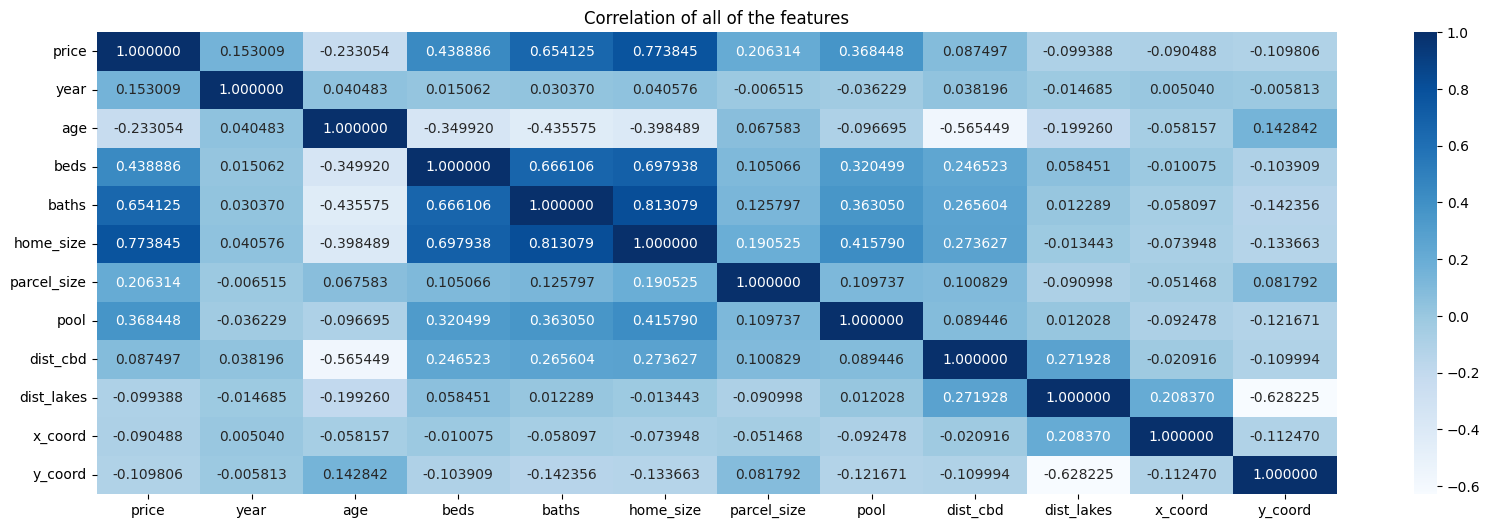

In [2]:
plt.figure(figsize=(20,6))
sns.heatmap(df.corr(),fmt="f",annot=True,cmap="Blues")
plt.title("Correlation of all of the features")
plt.show()


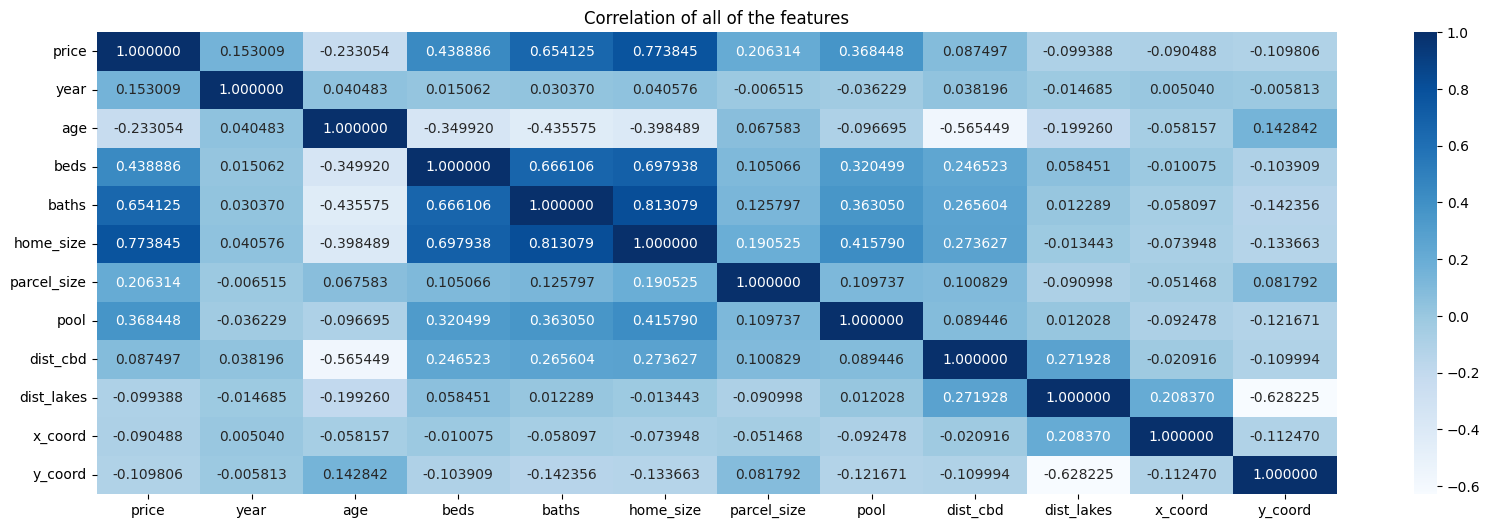

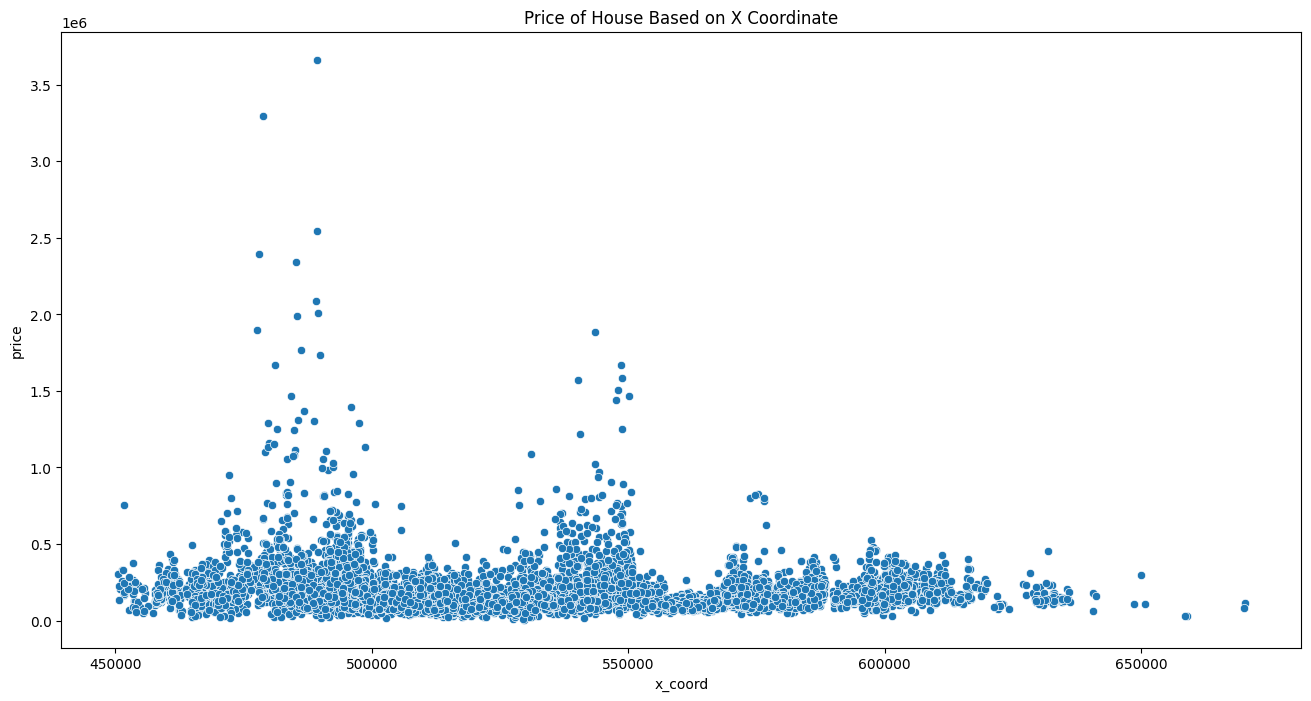

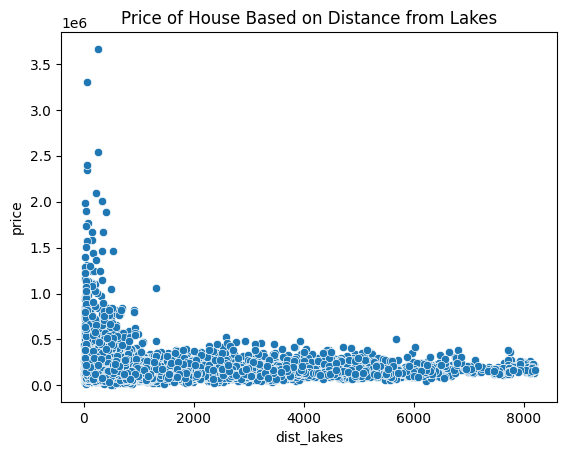

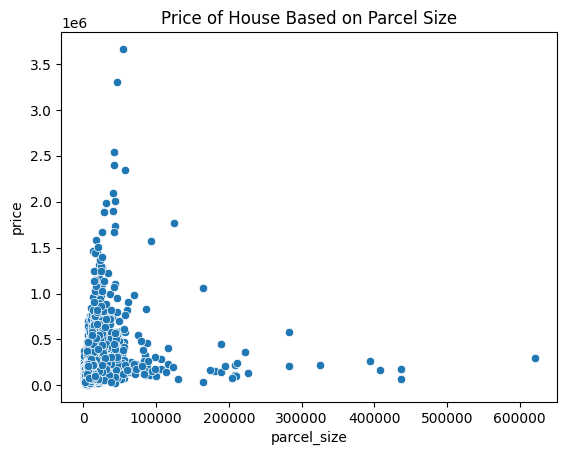

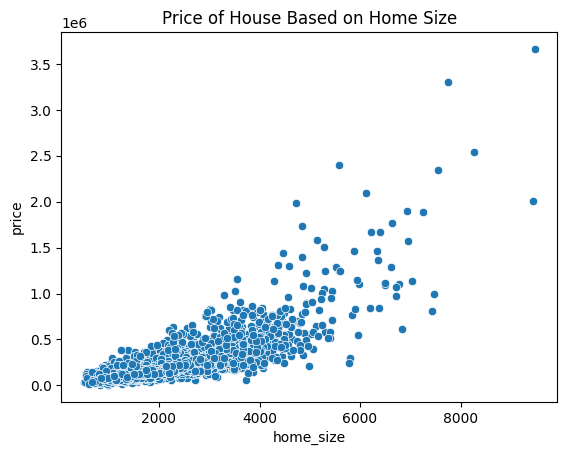

In [3]:
plt.figure(figsize=(20,6))
sns.heatmap(df.corr(),fmt="f",annot=True,cmap="Blues")
plt.title("Correlation of all of the features")
plt.show()

plt.figure(figsize=(16,8))
sns.scatterplot(data=df,x='x_coord',y='price')
plt.title("Price of House Based on X Coordinate")
plt.show()
 
sns.scatterplot(data=df,x='dist_lakes',y='price')
plt.title('Price of House Based on Distance from Lakes')
plt.show()

sns.scatterplot(data=df,x='parcel_size',y='price')
plt.title("Price of House Based on Parcel Size")
plt.show()

sns.scatterplot(data=df,x='home_size',y='price')
plt.title("Price of House Based on Home Size")
plt.show()

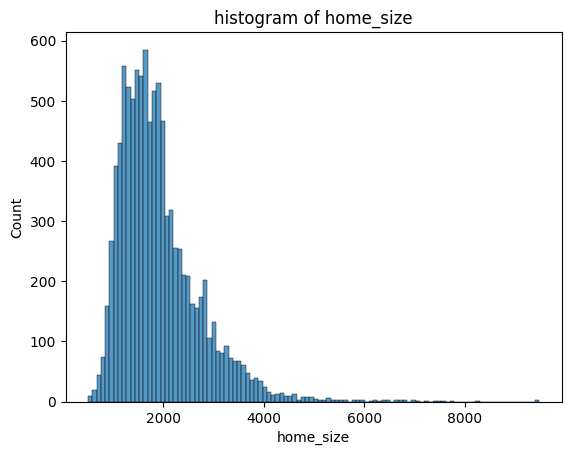

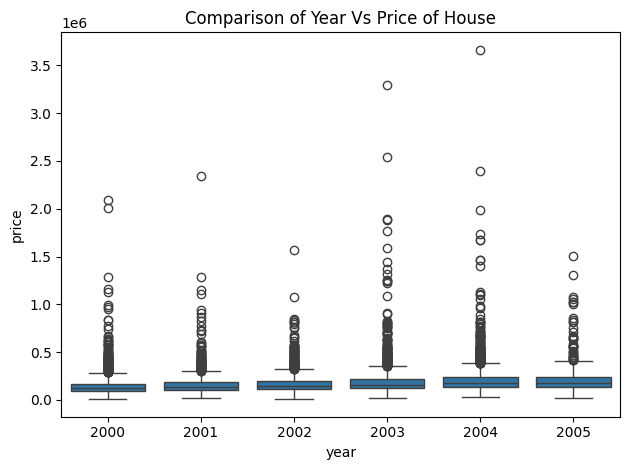

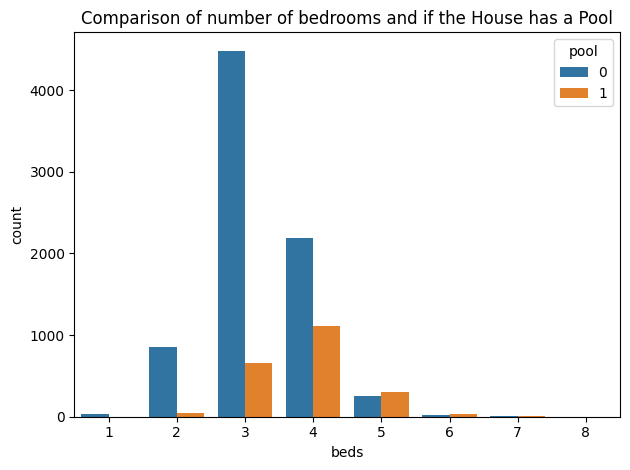

In [4]:

sns.histplot(data=df,x='home_size')
plt.title("histogram of home_size")
plt.show()


sns.boxplot(data=df,x='year',y='price')
plt.title("Comparison of Year Vs Price of House")
plt.tight_layout()
plt.show()

 
sns.countplot(data=df,x='beds',hue='pool')
plt.title("Comparison of number of bedrooms and if the House has a Pool")
plt.tight_layout()
plt.show()

In [5]:
X = df.drop('price',axis=1)
y = df['price']

olsmodel = sm.OLS(exog=sm.add_constant(X),endog=y).fit()
print(f'anova: {olsmodel.summary()}')


anova:                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     1819.
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        12:57:30   Log-Likelihood:            -1.2737e+05
No. Observations:                9997   AIC:                         2.548e+05
Df Residuals:                    9985   BIC:                         2.548e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.314e+07   1.09e+06    -21.21

In [6]:

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def evaluate(y_test,pred,model_name,r2,mse,cv_scores):


    result = {
        "Model": model_name,
        "R2": r2,
        "MSE": mse,
        "Cross-val Scores":cv_scores.mean()
    }

    return result


model_dict = []
models = {
    "LinearRegression":LinearRegression(),
    "lasso":Lasso(),
    "ridge":Ridge(),
    "GradientBoostingRegressor":GradientBoostingRegressor(),
    "BaggingRegressor":BaggingRegressor()
}



for model_name,model in models.items():
    model.fit(X_train_scaled,y_train)
    pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test,pred)
    r2 = r2_score(y_test,pred)
    cv_scores = cross_val_score(model, X_train_scaled,y_train,cv=10,scoring="neg_mean_squared_error")
    model_results = evaluate(y_test, pred, model_name,r2,mse,cv_scores)
    model_dict.append(model_results)



df_results = pd.DataFrame(model_dict)
print(df_results.head())

                       Model        R2           MSE  Cross-val Scores
0           LinearRegression  0.669861  4.928000e+09     -7.373574e+09
1                      lasso  0.669862  4.927979e+09     -7.373564e+09
2                      ridge  0.669889  4.927576e+09     -7.373586e+09
3  GradientBoostingRegressor  0.806269  2.891827e+09     -4.395238e+09
4           BaggingRegressor  0.801637  2.960970e+09     -4.438653e+09


In [7]:
linearregression_params = {
'copy_X': [True,False], 
'fit_intercept': [True,False], 
'n_jobs': [1000,5000,10000], 
'positive': [True,False]}



lasso_params = {
    'alpha': [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]
    }


ridge_params = {
    'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]
    }



gradientboosting_params = {
    'n_estimators': [50,100,200],
    'learning_rate': [0.01,0.1,0.2],
    'max_depth': [3,4,5],
    'min_samples_split': [2,5,10]
    }

bagginregression_params = {
    'n_estimators': [50,100,200],
    'max_samples' : [1.0,0.8,0.6],
    'max_features': [1.0,0.8,0.6]
}



models = {
    "LinearRegression":(LinearRegression(),linearregression_params),
    "Lasso":(Lasso(),lasso_params),
    "ridge":(Ridge(),ridge_params),
    "GradientBoostingRegresser":(GradientBoostingRegressor(),gradientboosting_params),
    "BaggingREgressor":(BaggingRegressor(),bagginregression_params),
    }

best_scores = []

for model_name,(model,params) in models.items():
    grid_search = RandomizedSearchCV(model,params,scoring="neg_mean_squared_error",cv=4)
    grid_search.fit(X_train_scaled,y_train)
    print(f'Best Params for {model_name}: {grid_search.best_params_}')
    print(f'Best Score for {model_name}: {grid_search.best_score_}')
    best_scores.append({"Model":model_name,"Neg-Mean-Average-MSE":grid_search.best_score_})
    

best_scores_df = pd.DataFrame(best_scores)
print(best_scores_df.head())

Best Params for LinearRegression: {'positive': False, 'n_jobs': 5000, 'fit_intercept': True, 'copy_X': False}
Best Score for LinearRegression: -7406106356.494888
Best Params for Lasso: {'alpha': 100}
Best Score for Lasso: -7405685930.618314
Best Params for ridge: {'alpha': 1e-15}
Best Score for ridge: -7406106356.494885
Best Params for GradientBoostingRegresser: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.2}
Best Score for GradientBoostingRegresser: -3789349913.150962
Best Params for BaggingREgressor: {'n_estimators': 50, 'max_samples': 0.8, 'max_features': 0.8}
Best Score for BaggingREgressor: -4013830608.7082376
                       Model  Neg-Mean-Average-MSE
0           LinearRegression         -7.406106e+09
1                      Lasso         -7.405686e+09
2                      ridge         -7.406106e+09
3  GradientBoostingRegresser         -3.789350e+09
4           BaggingREgressor         -4.013831e+09


In [12]:

"""Gradient Boosting Regressor with Best HyperParameters"""
gradient_boosting_regressor = GradientBoostingRegressor(n_estimators=200,min_samples_split=10,max_depth=2,learning_rate=0.2)
gradient_boosting_regressor.fit(X_train_scaled,y_train)
y_pred = gradient_boosting_regressor.predict(X_test_scaled)
print('Best Model With Optimized Hypder Parameters\n')
print(r2_score(y_test, y_pred))

Best Model With Optimized Hypder Parameters

0.8075136122136564


In [13]:







def predict(model,features):
    features = joblib.load("models/features.joblib")
    predictions = model.predict(features)
    return [[pred] for pred in predictions] 

if __name__ == "__main__":

    model = joblib.load("models/gbr.joblib")


    features = joblib.load("models/features.joblib")


    predictions = predict(model,features)


    print("Predictions:")
    for i, pred in enumerate(predictions):
        if (i+1) % 100 == 0:
            print(f'Sample {i+1}: Prediction of House Price = (${round(pred[0],2)}')


Predictions:
Sample 100: Prediction of House Price = ($207092.85
Sample 200: Prediction of House Price = ($84602.34
Sample 300: Prediction of House Price = ($238153.54
Sample 400: Prediction of House Price = ($91650.0
Sample 500: Prediction of House Price = ($311327.88
Sample 600: Prediction of House Price = ($168308.46
Sample 700: Prediction of House Price = ($133277.75
Sample 800: Prediction of House Price = ($136643.06
Sample 900: Prediction of House Price = ($18488.43
Sample 1000: Prediction of House Price = ($171196.64
Sample 1100: Prediction of House Price = ($172217.82
Sample 1200: Prediction of House Price = ($174718.96
Sample 1300: Prediction of House Price = ($145794.14
Sample 1400: Prediction of House Price = ($272008.96
Sample 1500: Prediction of House Price = ($164123.64
Sample 1600: Prediction of House Price = ($87621.4
Sample 1700: Prediction of House Price = ($125772.3
Sample 1800: Prediction of House Price = ($104190.63
Sample 1900: Prediction of House Price = ($84858.